<a href="https://colab.research.google.com/github/joaopamaral/tcc_puc_cdbd/blob/master/Analise_Storybook_CENIPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise dados CENIPA para construção do Storybook

![Descrição CENIPA](https://raw.githubusercontent.com/zezente/opendata_aig_brazil/master/reference/data_model.png)

## Importando as bibliotecas utilizadas

In [0]:
import pandas as pd
import folium
from folium import plugins
import matplotlib.pyplot as plt
%matplotlib inline

## Realizando leitura dos dados da CENIPA

In [0]:
cenipa_url = 'http://sistema.cenipa.aer.mil.br/cenipa/media/opendata'

oco_df = pd.read_csv(f'{cenipa_url}/oco.csv', sep='~', index_col='codigo_ocorrencia', parse_dates=['ocorrencia_dia'])
ftc_df = pd.read_csv(f'{cenipa_url}/ftc.csv', sep='~')
# rec_df = pd.read_csv(f'{cenipa_url}/rec.csv', sep='~')
anv_df = pd.read_csv(f'{cenipa_url}/anv.csv', sep='~')

In [0]:
for col in ['fator_nome', 'fator_aspecto', 'fator_condicionante', 'fator_area']:
    oco_df = oco_df.join(ftc_df[['codigo_ocorrencia', col]].drop_duplicates().groupby('codigo_ocorrencia')[col].apply(', '.join))

In [0]:
oco_df = oco_df.join(anv_df.groupby('codigo_ocorrencia')['total_fatalidades'].sum())

In [23]:
print(f'Quantidade de ocorrências: {oco_df.shape[0]}')
print(f'Ocorrências registradas de {oco_df.ocorrencia_dia.min().date()} a {oco_df.ocorrencia_dia.max().date()}')
display(oco_df.head())
print('\n')
display(oco_df.describe(include='all'))

Quantidade de ocorrências: 5460
Ocorrências registradas de 2009-01-01 a 2019-05-29


,ocorrencia_classificacao,ocorrencia_tipo,ocorrencia_tipo_categoria,ocorrencia_tipo_icao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_pais,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_horario,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista,ocorrencia_dia_extracao,fator_nome,fator_aspecto,fator_condicionante,fator_area,total_fatalidades
codigo_ocorrencia,,,,,,,,,,,,,,,,,,,,,,,,,,
201305055424986,ACIDENTE,FALHA DO MOTOR EM VOO,FALHA OU MAU FUNCIONAMENTO DO MOTOR,SCF-PP,-9.9085,-63.0333,ARIQUEMES,RO,BRASIL,SJOG,2013-05-05,11:00:00,NaN,FINALIZADA,***,NÃO,NaN,0,1,NÃO,2019-05-31,NaN,NaN,NaN,NaN,0
201311259977425,INCIDENTE GRAVE,POUSO SEM TREM,CONTATO ANORMAL COM A PISTA,ARC,-11.4956,-61.4508,CACOAL,RO,BRASIL,SSKW,2013-11-25,12:32:00,NaN,FINALIZADA,IG-209/CENIPA/2013,SIM,2014-04-07,0,1,NÃO,2019-05-31,"COORDENAÇÃO DE CABINE, ESQUECIMENTO DO PILOTO",DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,0
201605160250139,INCIDENTE GRAVE,COLISÃO COM OBSTÁCULO DURANTE A DECOLAGEM E POUSO,COLISÃO COM OBSTÁCULO DURANTE A DECOLAGEM E POUSO,CTOL,-11.2644,-61.2589,CACOAL,RO,BRASIL,SSKW,2016-05-13,19:19:00,SIM,FINALIZADA,IG-084/CENIPA/2016,SIM,2019-03-11,7,1,NÃO,2019-05-31,"PERCEPÇÃO, PROCESSO DECISÓRIO, PROCESSOS ORGAN...","ASPECTO PSICOLÓGICO, DESEMPENHO DO SER HUMANO","INDIVIDUAL, ORGANIZACIONAL, OPERAÇÃO DA AERONAVE","FATOR HUMANO, FATOR OPERACIONAL",0
201805021421302,INCIDENTE,AERÓDROMO,AERÓDROMO,ADRM,-11.4956,-61.4508,CACOAL,RO,BRASIL,SSKW,2018-03-09,22:40:00,SIM,FINALIZADA,***,NÃO,NaN,0,1,NÃO,2019-05-31,NaN,NaN,NaN,NaN,0
201103187273112,INCIDENTE,OUTROS,OUTROS,OTHR,-13.1950,-60.8184,CEREJEIRAS,RO,BRASIL,****,2011-03-18,13:30:00,NaN,FINALIZADA,***,NÃO,NaN,0,1,NÃO,2019-05-31,NaN,NaN,NaN,NaN,0


,ocorrencia_classificacao,ocorrencia_tipo,ocorrencia_tipo_categoria,ocorrencia_tipo_icao,ocorrencia_latitude,ocorrencia_longitude,ocorrencia_cidade,ocorrencia_uf,ocorrencia_pais,ocorrencia_aerodromo,ocorrencia_dia,ocorrencia_horario,investigacao_aeronave_liberada,investigacao_status,divulgacao_relatorio_numero,divulgacao_relatorio_publicado,divulgacao_dia_publicacao,total_recomendacoes,total_aeronaves_envolvidas,ocorrencia_saida_pista,ocorrencia_dia_extracao,fator_nome,fator_aspecto,fator_condicionante,fator_area,total_fatalidades
count,5460,5460,5460,5460,5460.000000,5460.000000,5460,5460,5460,5460,5460,5460,1519,5460,5460,5460,1375,5460.000000,5460.000000,5460,5460,1126,1126,1126,1126,5460.000000
unique,3,71,31,29,NaN,NaN,1050,28,1,480,2822,935,3,2,1788,2,213,NaN,NaN,2,1,654,64,88,19,NaN
top,INCIDENTE,FALHA DO MOTOR EM VOO,FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPON...,SCF-NP,NaN,NaN,RIO DE JANEIRO,SP,BRASIL,****,2013-12-18 00:00:00,20:00:00,SIM,FINALIZADA,***,NÃO,2017-08-01,NaN,NaN,NÃO,2019-05-31,MANUTENÇÃO DE AERONAVE,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,NaN
freq,3073,651,1160,1723,NaN,NaN,319,1310,5460,2172,9,114,1406,4875,3389,4089,62,NaN,NaN,5009,5460,63,518,355,553,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,-18.193427,-47.492499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.378571,1.011538,NaN,NaN,NaN,NaN,NaN,NaN,0.157875
std,NaN,NaN,NaN,NaN,8.894486,10.949421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.350778,0.115062,NaN,NaN,NaN,NaN,NaN,NaN,0.784059
min,NaN,NaN,NaN,NaN,-224.164700,-72.781100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,-23.330300,-51.171100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


## Analisando as ocorrências no Brasil

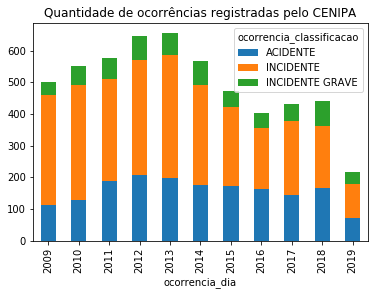

In [50]:
oco_df.groupby([oco_df.ocorrencia_dia.dt.year, 'ocorrencia_classificacao'])['ocorrencia_tipo'].count().unstack().plot.bar(stacked=True, title="Quantidade de ocorrências registradas pelo CENIPA");

In [52]:
m=folium.Map([-15.4647,-47.5547], zoom_start=4, width=700, height=500)
location_data = oco_df[['ocorrencia_latitude', 'ocorrencia_longitude']].values
# plot heatmap
m.add_child(plugins.HeatMap(location_data, radius=15))

In [46]:
m=folium.Map([-15.4647,-47.5547], zoom_start=4, width=700, height=500)
filtro_fator_humano = (oco_df.fator_area.str.contains('FATOR HUMANO') | oco_df.fator_aspecto.str.contains('DESEMPENHO DO SER HUMANO'))
location_data_humano = oco_df.loc[filtro_fator_humano, ['ocorrencia_latitude', 'ocorrencia_longitude']].values
# plot heatmap
m.add_child(plugins.HeatMap(location_data_humano, radius=15))

In [53]:
display(ftc_df.head())
print('\n')
display(ftc_df.describe(include='all'))

,codigo_ocorrencia,fator_nome,fator_aspecto,fator_condicionante,fator_area,fator_detalhe_fator,fator_dia_extracao
0,200901015424167,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,"A PROVÁVEL INTENÇÃO EM PRESERVAR A AERONAVE, C...",2019-05-31
1,200901015424167,MANUTENÇÃO DE AERONAVE,DESEMPENHO DO SER HUMANO,MANUTENÇÃO DA AERONAVE,FATOR OPERACIONAL,O RELATÓRIO TÉCNICO DO IAE REVELOU FALHAS ORIU...,2019-05-31
2,200901015424167,SUPERVISÃO GERENCIAL,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,O OPERADOR NÃO PROGRAMOU A REALIZAÇÃO DE INSPE...,2019-05-31
3,200901055963381,ATITUDE,ASPECTO PSICOLÓGICO,INDIVIDUAL,FATOR HUMANO,O PILOTO ERA POUCO EXPERIENTE E REALIZOU O POU...,2019-05-31
4,200901055963381,PROCESSO DECISÓRIO,ASPECTO PSICOLÓGICO,INDIVIDUAL,FATOR HUMANO,"A POUCA EXPERIÊNCIA DO PILOTO, ALIADA AO EXCES...",2019-05-31


,codigo_ocorrencia,fator_nome,fator_aspecto,fator_condicionante,fator_area,fator_detalhe_fator,fator_dia_extracao
count,4.630000e+03,4630,4630,4630,4630,2710,4630
unique,NaN,68,10,7,4,2685,1
top,NaN,JULGAMENTO DE PILOTAGEM,DESEMPENHO DO SER HUMANO,OPERAÇÃO DA AERONAVE,FATOR OPERACIONAL,SUMA,2019-05-31
freq,NaN,583,2782,2496,2866,10,4630
mean,2.012628e+14,NaN,NaN,NaN,NaN,NaN,NaN
std,2.533158e+11,NaN,NaN,NaN,NaN,NaN,NaN
min,2.009010e+14,NaN,NaN,NaN,NaN,NaN,NaN
25%,2.010121e+14,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.012100e+14,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.015020e+14,NaN,NaN,NaN,NaN,NaN,NaN


,TOTAL DE FATALIDADES
FATOR HUMANO,486
OUTROS FATORES,376


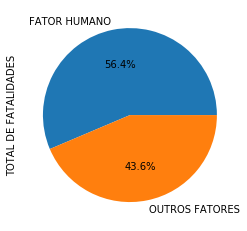

In [54]:
fatal_df = pd.DataFrame([oco_df.loc[filtro_fator_humano, 'total_fatalidades'].sum(), oco_df.loc[~filtro_fator_humano, 'total_fatalidades'].sum()], ['FATOR HUMANO', 'OUTROS FATORES'], ['TOTAL DE FATALIDADES'])
display(fatal_df)
fatal_df['TOTAL DE FATALIDADES'].plot.pie(autopct='%1.1f%%');

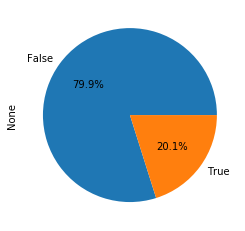

In [55]:
(oco_df.fator_area.str.contains('FATOR HUMANO') | oco_df.fator_aspecto.str.contains('DESEMPENHO DO SER HUMANO')).value_counts().plot.pie(autopct='%1.1f%%');

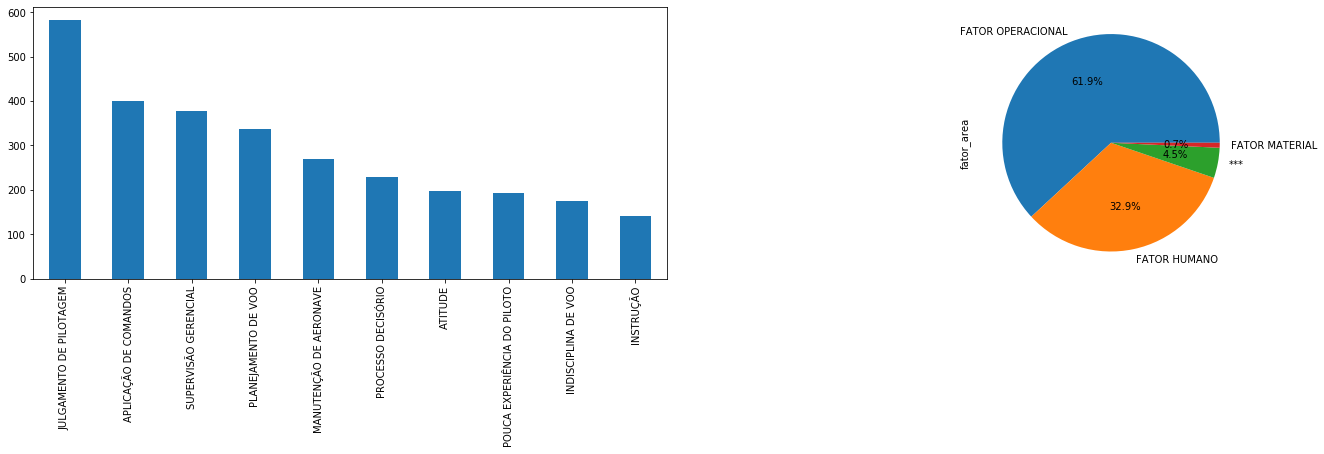

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 5))
ftc_df.fator_nome.value_counts().nlargest(10).plot.bar(ax=ax1);
ftc_df.fator_area.value_counts().plot.pie(autopct='%1.1f%%', ax=ax2);